# 임베딩 클러스터 시각화(t-SNE)

In [15]:
import pandas as pd
import json
import numpy as np

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [16]:
def plot_tsne_by_tag(x: list, tags: list[str], perplexity: float, max_iter: int):
    x = np.asarray(x)
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        learning_rate='auto',
        max_iter=max_iter,
        init='pca',
        verbose=1
    )
    transformed_x = tsne.fit_transform(x)

    tags = pd.Series(tags, dtype='category')
    plt.figure(figsize=(8,6))
    for cat in tags.cat.categories:
        m = (tags == cat).to_numpy()
        plt.scatter(transformed_x[m,0], transformed_x[m,1], s=12, alpha=0.8, label=str(cat))
    
    plt.title('t-SNE')
    plt.tight_layout()
    plt.show()

In [ ]:
embedding_df = pd.read_csv('./assets/tourspot_embeddings.csv')
tourspots_df = pd.read_csv('./assets/tourspots_full_transformed.csv')

tourspots_df['tags'] = tourspots_df['tags'].apply(lambda x: json.loads(x)[0])

merged = pd.merge(tourspots_df, embedding_df, on='id')

merged.drop_duplicates(subset=['id', 'embedding'], inplace=True)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 4336 samples in 0.006s...
[t-SNE] Computed neighbors for 4336 samples in 3.148s...
[t-SNE] Computed conditional probabilities for sample 1000 / 4336
[t-SNE] Computed conditional probabilities for sample 2000 / 4336
[t-SNE] Computed conditional probabilities for sample 3000 / 4336
[t-SNE] Computed conditional probabilities for sample 4000 / 4336
[t-SNE] Computed conditional probabilities for sample 4336 / 4336
[t-SNE] Mean sigma: 0.103354
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.297333
[t-SNE] KL divergence after 2000 iterations: 1.745893


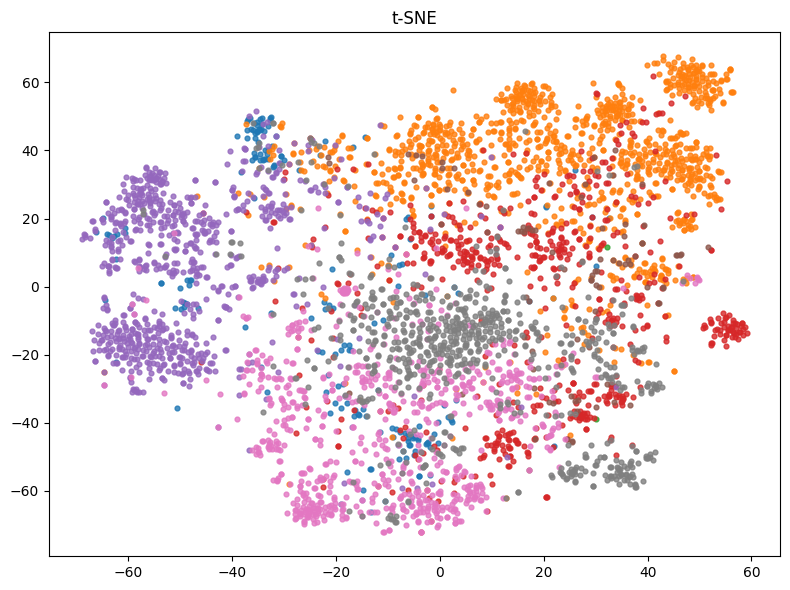

In [19]:
plot_tsne_by_tag(
    x=merged['embedding'].apply(json.loads).to_list(),
    tags=merged['tags'].to_list(),
    perplexity=40,
    max_iter=2000
)

# 검색 성능 평가

In [20]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

In [22]:
nn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=11)
nn.fit(merged['embedding'].apply(json.loads).to_list())

,n_neighbors,11
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


In [23]:
def precision_at_k(query, neighbors, tags, k=10):
    query_tag = tags[query]
    neighbor_tags = [tags[i] for i in neighbors[:k]]
    correct = sum(1 for t in neighbor_tags if t == query_tag)
    return correct / k

Precision@k: 0.6507380073800738


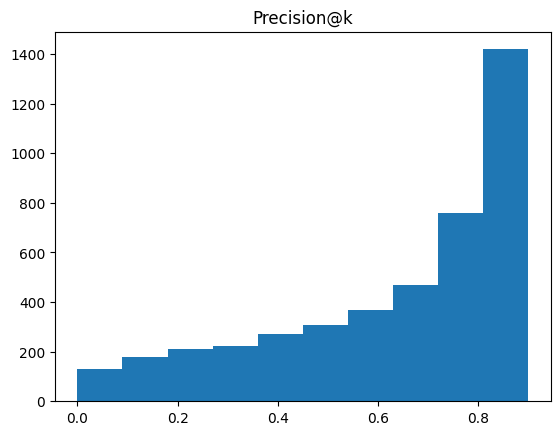

In [31]:
dist, neighbor_idx = nn.kneighbors(merged['embedding'].apply(json.loads).to_list())
neighbor_idx = neighbor_idx[:, 1:10]

pak = []
for i in range(len(merged)):
    score = precision_at_k(i, neighbor_idx[i], merged['tags'], 10)
    pak.append(score)
print('Precision@k:', sum(pak) / len(merged))
plt.hist(pak, bins=10)
plt.title('Precision@k')
plt.show()

In [29]:
import random

choice = random.choice(range(len(merged)))

query = merged.iloc[choice]
print('[검색 관광지]')
print(query['name'], '-', query['description'])
print()

print('[이웃 관광지]')
for ni in neighbor_idx[choice]:
    neighbor = merged.iloc[ni]
    print(neighbor['name'], '-', neighbor['description'])
    print()

[검색 관광지]
마로니에공원 - 마로니에공원은 서울 시민들을 위한 문화예술의 터전으로 옛 서울대학교 문리대, 법대 자리에 있다. 이곳에는 마로니에나무가 자라고 있는데 1929년 4월 5일 서울대학교의 전신인 경성제국대학 시절에 심은 것으로, 이 나무 이름을 따서 마로니에공원이라는 이름이 붙었다.
어린이놀이터가 있고 야외무대와 분수공원, 조각품 등이 전시되어 있다. 야외무대는 가수들의 공연장과 각종 문화행사장으로 활용되고 있다. 이 공원 주위로 문예회관 대극장과 바탕골소극장, 동숭아트센터 등의 소극장이 자리하고 있다. 유명한 맛집과 다양한 컨셉의 카페들이 주위에 많다. 이 공원에서는 연중무휴 무료로 개방되는 공연과 행사들에 많아서 언제 방문하더라도 참여하고 즐길 거리가 가득하다.

[이웃 관광지]
대학로 - 젊음의 열기가 가득한 대학로는 대한민국의 예술, 공연, 자유 등을 대표하는 문화 집결지라 할 수 있다. 대학로가 젊은이들에게 이처럼 아낌없는 사랑을 받았던 것은 서울대학교 문리대와 법대가 자리한 시절부터이다. 서울대학교 학생들을 중심으로 주변 대학 학생들과 젊은이들이 모여들었고, 자연스럽게 다른 어떤 장소와도 비교 불가한 대학로만의 개성을 만들어갔다. 1975년 서울대학교는 관악산 아래로 캠퍼스를 이전했다. 그러나 그 자리에는 아름드리 마로니에 나무가 있어 ‘마로니에공원’이라 이름 붙은 공원이 조성되었다. 이후 젊은이들과 방문자들을 위한 연극, 뮤지컬 등의 크고 작은 문화시설들이 하나 둘 들어서게 되면서 비로소 오늘날의 대학로가 완성되었다. 
서울시는 1985년 5월 대학로를 ‘문화예술의 거리’로, 인사동에 이어 두 번째로 2004년에 ‘문화지구’에 지정했다. 문화지구는 문화자원이 밀집된 장소를 선별해 시장뿐 아니라 정부 차원에서도 보호하고 관리할 필요성을 느껴 선정한다. 대학로의 공연 예술을 활성화시키고 방문객을 늘면서도 상업 관련 시설이 주가 되는 것은 지양하고 소극장 및 문화시설을 보호하기 위함이다. 앞으로도 대학로만의 순수한 낭만과 예술이 번창하는 곳